In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score as f1
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import decomposition

from catboost import CatBoostClassifier

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Установка опорного элемента для генератора псевдослучайной последовательности

In [2]:
rnd_st = 11

# Чтение набора размеченных данных

In [3]:
data_train = pd.read_csv('data_train.csv')
data_train.shape

(831653, 5)

### Оценим сбалансированность классов.

In [4]:
data_train["target"].value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

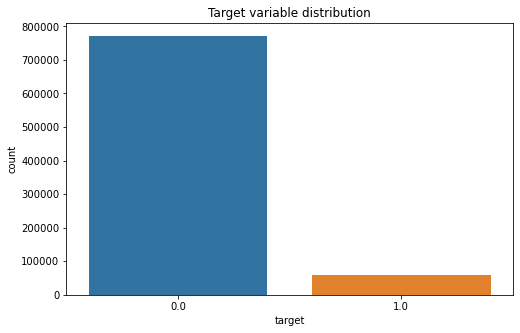

In [5]:
plt.figure(figsize=(8, 5))

sns.countplot(x="target", data=data_train)

plt.title('Target variable distribution')
plt.show()

### Посмотрим на сбалансированность классов для каждой категории.

In [6]:
vas_id_vals = data_train["vas_id"].value_counts().sort_values(ascending=False)
vas_id_vals

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

Распределение классов для услуги 1.0
0.0    0.981739
1.0    0.018261
Name: target, dtype: float64


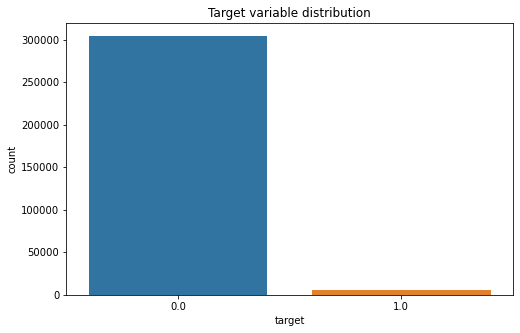

Распределение классов для услуги 2.0
0.0    0.980774
1.0    0.019226
Name: target, dtype: float64


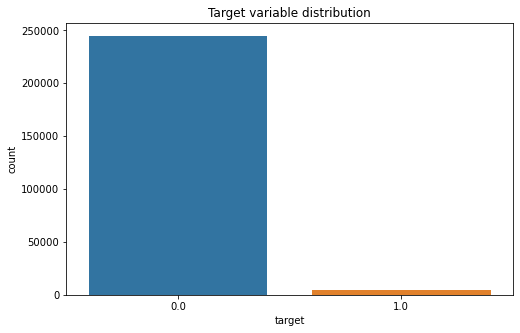

Распределение классов для услуги 5.0
0.0    0.982016
1.0    0.017984
Name: target, dtype: float64


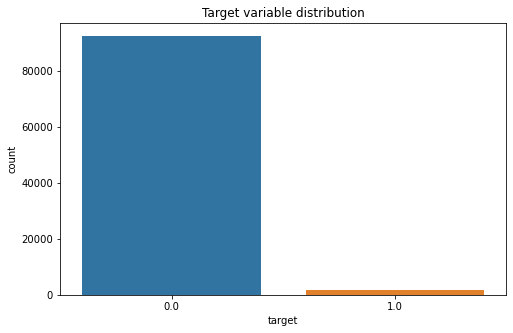

Распределение классов для услуги 4.0
0.0    0.746199
1.0    0.253801
Name: target, dtype: float64


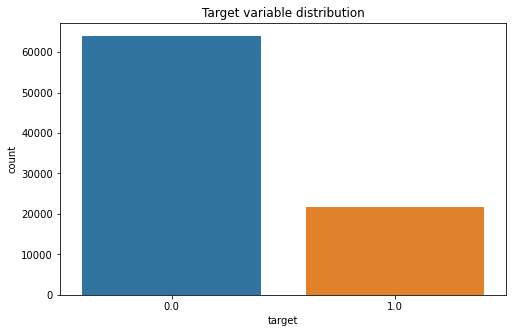

Распределение классов для услуги 6.0
0.0    0.573171
1.0    0.426829
Name: target, dtype: float64


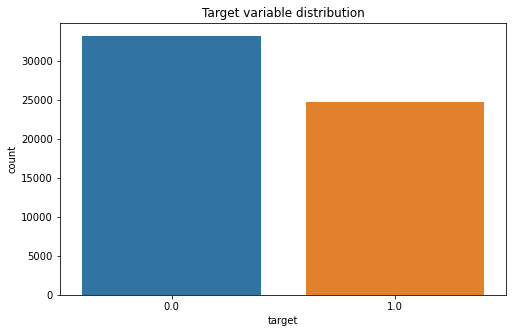

Распределение классов для услуги 7.0
0.0    0.986198
1.0    0.013802
Name: target, dtype: float64


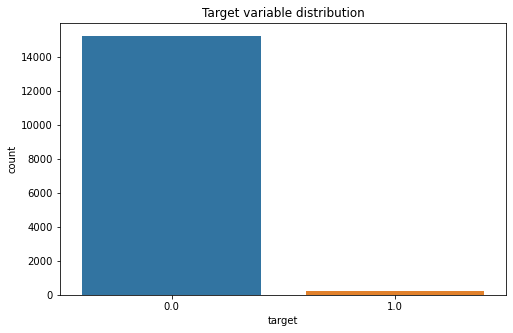

Распределение классов для услуги 8.0
0.0    0.974007
1.0    0.025993
Name: target, dtype: float64


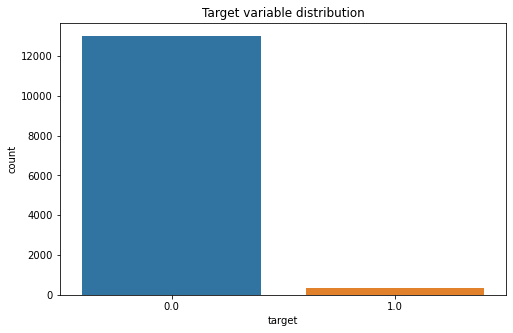

Распределение классов для услуги 9.0
0.0    0.81652
1.0    0.18348
Name: target, dtype: float64


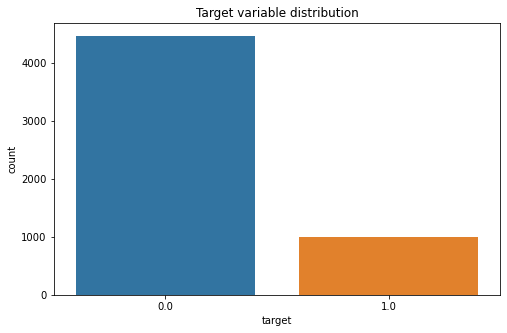

In [7]:
for ids in vas_id_vals.index.tolist():
    
    print(f"Распределение классов для услуги {ids}")
    
    print(data_train.loc[data_train["vas_id"] == ids]["target"].value_counts(normalize=True))
    
    plt.figure(figsize=(8, 5))

    sns.countplot(x="target", data=data_train.loc[data_train["vas_id"] == ids])

    plt.title('Target variable distribution')
    plt.show()

# Чтение набора признаков, характеризующих профиль потребления

In [8]:
features = dd.read_csv('features.csv', sep='\t')

In [9]:
print(f"Количество записей в таблице с профилями потребления {len(features)}")

Количество записей в таблице с профилями потребления 4512528


In [10]:
features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


# Формирование набора данных для обучения модели

In [11]:
ddf_train = features.merge(data_train, suffixes=('_features', ''), how='inner', on=['id'])

In [12]:
df_train = pd.DataFrame()

In [13]:
df_train = ddf_train.compute()

In [14]:
# создадим столбец с модулем разности времён (для определения ближайшего профиля)
df_train['buy_time_diff'] = df_train['buy_time_features'] - df_train['buy_time']
df_train['buy_time_diff'] = df_train['buy_time_diff'].abs()
df_train.head()

,Unnamed: 0_features,id,buy_time_features,0,1,2,3,4,5,6,...,248,249,250,251,252,Unnamed: 0,vas_id,buy_time,target,buy_time_diff
0,13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-17.832889,-0.694428,-4.175933,-0.45614,0.0,53522,2.0,1544389200,0.0,9676800
1,16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,236388,1.0,1536526800,0.0,4233600
2,19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,...,-24.832889,0.305572,-12.175933,-0.45614,1.0,164414,1.0,1532293200,0.0,8467200
3,20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,...,-25.832889,-0.694428,-12.175933,-0.45614,0.0,194665,1.0,1535317200,0.0,9676800
4,22,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,...,-14.832889,2.305572,-4.175933,-0.45614,0.0,343025,2.0,1544389200,0.0,10886400


In [15]:
# сгруппируем по записям из таблицы data_train
df_grouped = df_train.groupby(by=['id', 'vas_id', 'buy_time'])

In [16]:
# найдём минимальные разности времён
min_diffs = df_grouped['buy_time_diff'].min()

In [17]:
# восстановим датафрейм
min_diffs = min_diffs.reset_index(level=['id', 'vas_id', 'buy_time'])

In [18]:
# выберем те профили, которые ближе к дате взаимодействия с услугой
df_train = df_train.merge(min_diffs, how='inner', on=['id', 'vas_id', 'buy_time', 'buy_time_diff'])

In [19]:
# объединим
df_grouped = df_train.groupby(by=['id', 'vas_id', 'buy_time', 'buy_time_diff'])

In [20]:
# выберем профиль предшествующий взаимодействию с услугой, если их несколько
min_diffs = df_grouped['buy_time_features'].min()

In [21]:
# восстановим датафрейм
min_diffs = min_diffs.reset_index(level=['id', 'vas_id', 'buy_time', 'buy_time_diff'])

In [22]:
# получим итоговую таблицу
df_train = df_train.merge(min_diffs, how='inner', on=['id', 'vas_id', 'buy_time', 'buy_time_diff', 'buy_time_features'])

In [23]:
# удалим столбец, который создавали для агрегации
df_train.drop('buy_time_diff', axis=1, inplace=True)

In [24]:
# удалим ненужные столбцы
df_train.drop(["Unnamed: 0_features", "Unnamed: 0", "buy_time_features", "buy_time", "id"], axis=1, inplace=True)

In [25]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,vas_id,target
0,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,-30.006538,...,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0,2.0,0.0
1,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,-30.006538,...,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1.0,0.0
2,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,-30.006538,...,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0,1.0,0.0
3,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,-6.78366,-30.006538,...,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,1.0,0.0
4,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,-6.78366,262.137382,...,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0,2.0,0.0


# Определение неинформативных признаков

In [26]:
# отделим целевой признак
train_X_df = df_train.copy()
train_Y_sr = train_X_df["target"]
vas_id = train_X_df["vas_id"]
train_X_df.drop(["target", "vas_id"], axis=1, inplace=True)

In [27]:
X_nunique = train_X_df.apply(lambda x: x.nunique(dropna=False))

In [28]:
X_nunique.shape

(253,)

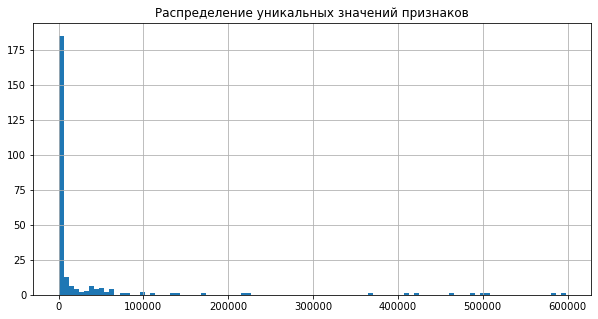

In [29]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [30]:
f_all = set(X_nunique.index.tolist())
len(f_all)

253

In [31]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

5

### Удалим константные признаки

In [32]:
train_X_df.drop(f_const, axis=1, inplace=True)
train_X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
1,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,-30.006538,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
3,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,-6.78366,-30.006538,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,-6.78366,262.137382,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


# Оценка распределения кумулятивной дисперсии по признакам

In [33]:
# масштабирование данных
scaler = StandardScaler()

X_train_scaled = train_X_df.copy()  # данные для классификации
scaler.fit(X_train_scaled)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_scaled), columns=X_train_scaled.columns)

X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1.003331,3.252484,0.936107,2.849421,0.883496,2.551882,-0.064646,1.664190,-0.058598,-0.153523,...,-0.306714,-0.275667,-0.019358,-0.118182,-0.227655,-0.067252,-0.094156,-0.021433,-0.039467,-0.123285
1,-0.288832,0.183258,-0.276669,0.194887,-0.283275,0.142099,-0.064646,-0.168805,-0.058598,-0.153523,...,-0.306714,-0.275667,-0.017890,0.632717,-0.220699,-0.097394,-0.094156,-0.060568,-0.039467,-0.123285
2,-0.324189,-0.834619,-0.362428,-0.833171,-0.359120,-0.787707,-0.064646,-0.168805,-0.058598,-0.153523,...,-0.290405,-0.252344,-0.016422,-0.124827,-0.116361,-0.093626,0.048032,-0.060568,-0.039467,0.353919
3,-0.317979,-0.744069,-0.356354,-0.743959,-0.359937,-0.710185,-0.064646,-0.168805,-0.058598,-0.153523,...,-0.306714,-0.275667,-0.019358,-0.124827,-0.236157,-0.097394,-0.094156,-0.060568,-0.039467,-0.123285
4,-0.253542,1.359660,-0.293324,1.314552,-0.299299,1.200068,-0.064646,1.991411,-0.058598,1.324887,...,-0.157422,-0.109271,-0.019358,-0.124827,-0.128727,-0.055949,0.332408,-0.021433,-0.039467,-0.123285


In [34]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_train_scaled.T.dot(X_train_scaled)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
14440859.3693982
8489512.85699315
6303146.7891774615
5652838.535384064
4783798.091826936
4534100.152915882
3686183.189862435
3558865.5298013054
3348093.264431273
3082785.0887083705
3048701.6019851128
2960475.972946392
2865563.4304045937
2600796.3453301303
2546005.795859641
2443002.062092106
2400866.055783581
2369178.5117150233
2232730.7372430745
2156208.9529752396
2072656.1194334542
1949147.8472983055
1907837.9188052223
1872025.0511150614
1813896.2475330606
1744804.9206538629
1735046.0291682454
1725822.1459749776
1657972.4637000572
1616487.602705721
1600147.0173849137
1577077.273331427
1541691.0785676318
1516566.9894450887
1484241.7495859114
1474450.794785866
1464939.9138548982
1415524.1662257602
1394614.4793282622
1355857.1833269766
1350190.1621633852
1335985.9390035858
1326015.0080845952
1291034.326786042
1254484.1935196542
1220281.1247280582
1184177.3225476185
1166729.048379261
1155634.6357828015
1145382.5572898814
1120539.71784538
1107830.67

In [35]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[(7.001630686211568+0j), (4.116128563406123+0j), (3.056072000280131+0j), (2.7407709431349243+0j), (2.3194178864004575+0j), (2.198352186178472+0j), (1.7872408197417151+0j), (1.7255110284060484+0j), (1.6233183871464552+0j), (1.4946840852031285+0j), (1.4781587538201257+0j), (1.4353826796415452+0j), (1.3893644647023944+0j), (1.2609925098113606+0j), (1.2344273877037448+0j), (1.1844861698930214+0j), (1.1640565855298253+0j), (1.1486929236281485+0j), (1.0825364089519804+0j), (1.0454349277182038+0j), (1.0049244519714635+0j), (0.9450416371013909+0j), (0.9250125754241266+0j), (0.9076487560719328+0j), (0.8794650860768511+0j), (0.8459662518278597+0j), (0.8412346667925603+0j), (0.8367624797876185+0j), (0.803865655207186+0j), (0.7837517777487096+0j), (0.775829067563243+0j), (0.7646437340760801+0j), (0.7474867865019293+0j), (0.7353054066502369+0j), (0.7196325588267353+0j), (0.7148854279377953+0j), (0.7102740904767934+0j), (0.6863149336058766+0j), (0.676

In [36]:
print(f"{cum_var_exp[90]} % всей дисперсии данных приходится на первые 90 компонент.")

(80.17755290062819+0j) % всей дисперсии данных приходится на первые 90 компонент.


In [37]:
print(f"{cum_var_exp[122]} % всей дисперсии данных приходится на первые 122 компоненты.")

(90.08649844344839+0j) % всей дисперсии данных приходится на первые 122 компоненты.


### Итоговая таблица для обуцения модели будет иметь 831653 строк и около 249 столбцов. Подбор алгоритма на такой таблице займёт много времени.

# Формирование таблицы для подбора алгоритма машинного обучения

In [38]:
# Объединение сделаем по двум полям только лишь для уменьшения итоговой таблицы
#объединённая таблица
ddf_train_reduced = features.merge(data_train, suffixes=('_features', ''), how='inner', on=['id', 'buy_time'])

In [39]:
df_train_reduced = pd.DataFrame()

In [40]:
# получим пандасовский датафрейм
df_train_reduced = ddf_train_reduced.compute()

In [41]:
df_train_reduced.shape

(38919, 259)

In [42]:
df_train_reduced.head()

,Unnamed: 0_features,id,buy_time,0,1,2,3,4,5,6,...,246,247,248,249,250,251,252,Unnamed: 0,vas_id,target
0,158,2535255,1533502800,74.810029,176.560888,76.129214,139.213202,70.711754,118.10821,-16.08618,...,-19.630448,-261.747724,-21.832889,-0.694428,-8.175933,-0.45614,0.0,434813,1.0,0.0
1,514,3764561,1544994000,-96.799971,-399.789112,-110.740786,-452.396798,-116.158246,-347.23179,-16.08618,...,-26.630448,-53.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0,655731,2.0,0.0
2,559,3819821,1538341200,-95.269971,193.430888,-109.210786,140.823202,-114.628246,119.71821,-16.08618,...,-30.630448,-244.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,302696,2.0,0.0
3,574,3831671,1541970000,-81.549971,33.340888,82.449214,565.393202,77.031754,544.28821,-16.08618,...,-37.630448,-168.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0,769150,2.0,0.0
4,864,4109995,1544994000,-96.799971,66.400888,-110.740786,13.793202,-116.158246,-7.31179,-16.08618,...,-36.630448,54.252276,-21.832889,0.305572,-12.175933,-0.45614,0.0,21122,2.0,0.0


Удалим ненужные столбцы

In [43]:
df_train_reduced.drop(["Unnamed: 0_features", "Unnamed: 0", "buy_time", "id"], axis=1, inplace=True)

### Проверим, что распределение классов в категориях услуг соответствует исходному набору данных

In [44]:
df_train_reduced["target"].value_counts(normalize=True)

0.0    0.932115
1.0    0.067885
Name: target, dtype: float64

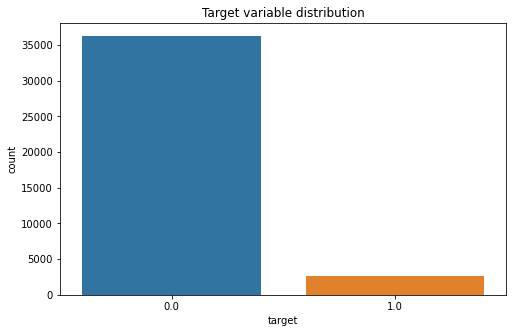

In [45]:
plt.figure(figsize=(8, 5))

sns.countplot(x="target", data=df_train_reduced)

plt.title('Target variable distribution')
plt.show()

Распределение классов для услуги 1.0
0.0    0.987793
1.0    0.012207
Name: target, dtype: float64


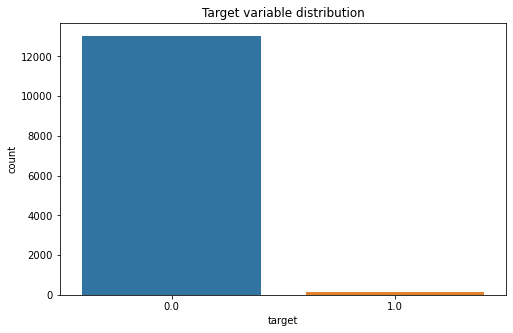

Распределение классов для услуги 2.0
0.0    0.988265
1.0    0.011735
Name: target, dtype: float64


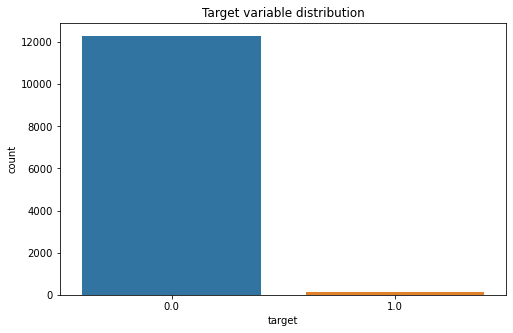

Распределение классов для услуги 5.0
0.0    0.990603
1.0    0.009397
Name: target, dtype: float64


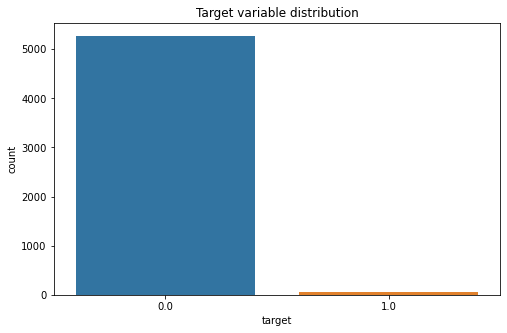

Распределение классов для услуги 4.0
0.0    0.754555
1.0    0.245445
Name: target, dtype: float64


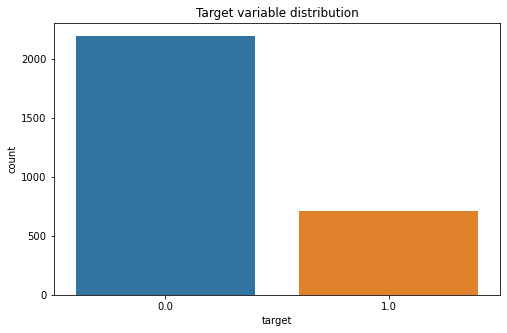

Распределение классов для услуги 6.0
0.0    0.581351
1.0    0.418649
Name: target, dtype: float64


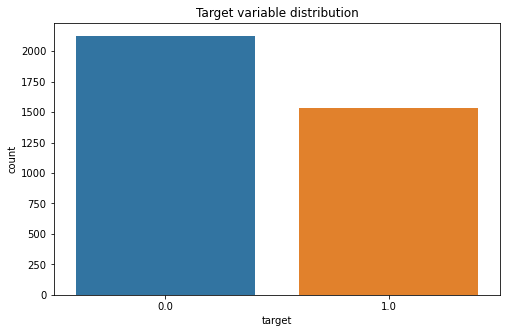

Распределение классов для услуги 7.0
0.0    0.989147
1.0    0.010853
Name: target, dtype: float64


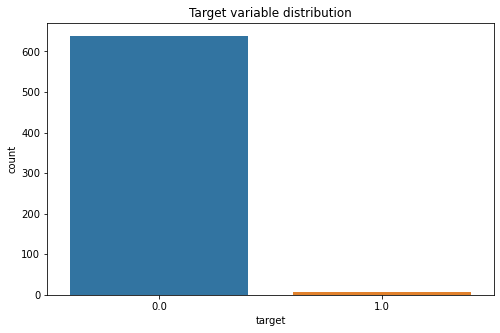

Распределение классов для услуги 8.0
0.0    0.989051
1.0    0.010949
Name: target, dtype: float64


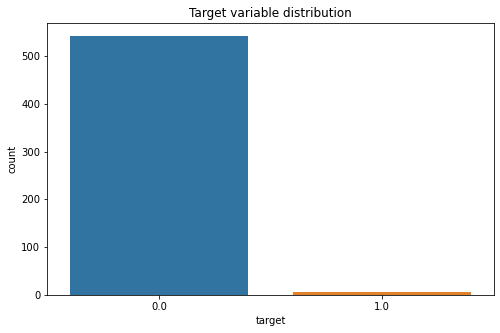

Распределение классов для услуги 9.0
0.0    0.870813
1.0    0.129187
Name: target, dtype: float64


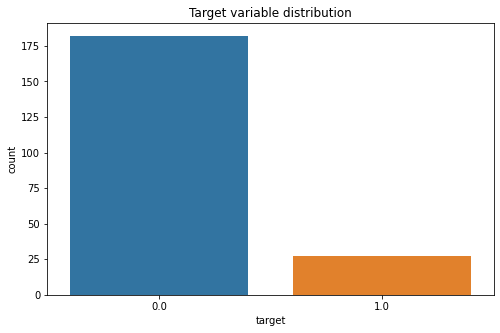

In [46]:
for ids in vas_id_vals.index.tolist():
    
    print(f"Распределение классов для услуги {ids}")
    
    print(df_train_reduced.loc[df_train_reduced["vas_id"] == ids]["target"].value_counts(normalize=True))
    
    plt.figure(figsize=(8, 5))

    sns.countplot(x="target", data=df_train_reduced.loc[df_train_reduced["vas_id"] == ids])

    plt.title('Target variable distribution')
    plt.show()

In [47]:
# удалим константные признаки
df_train_reduced.drop(f_const, axis=1, inplace=True)

### Отделим target и перемешаем данные

In [48]:
df_train_reduced['vas_id'] = df_train_reduced['vas_id'].astype(int)

In [49]:
# перемешаем данные
df_train_reduced = df_train_reduced.sample(frac=1, random_state=rnd_st).reset_index(drop=True)

In [50]:
# отделим целевой признак
train_X_df_reduced = df_train_reduced.copy()
train_Y_sr_reduced = train_X_df_reduced["target"]
train_X_df_reduced.drop(["target"], axis=1, inplace=True)

# Визуализация данных при помощи tSNE

In [51]:
# удалим категориальный признак для обучающей выборки
train_X_df_reduced_vas = train_X_df_reduced.copy()
vas_id_train_reduced = train_X_df_reduced_vas["vas_id"].copy()
train_X_df_reduced_vas.drop(["vas_id"], axis=1, inplace=True)

In [52]:
# масштабирование данных
scaler.fit(train_X_df_reduced_vas)
X_train_scaled_reduced = pd.DataFrame(scaler.transform(train_X_df_reduced_vas), columns=train_X_df_reduced_vas.columns)

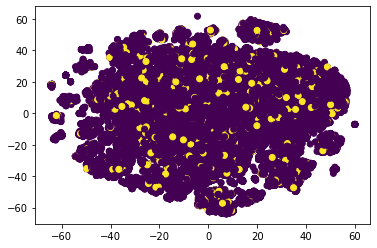

Wall time: 11min 33s


In [53]:
%%time

tSNE = TSNE(n_components=2, random_state=rnd_st)
X_train_tsne = tSNE.fit_transform(X_train_scaled_reduced)
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=train_Y_sr_reduced)

plt.show()

Визуально выделить хорошо различимые кластеры данных не получается.

### Кластеризация

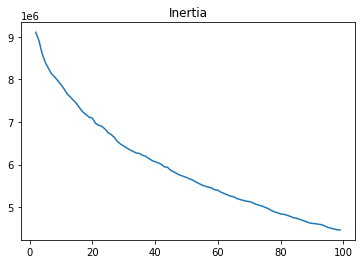

Wall time: 24min 22s


In [54]:
%%time

inertias = []
k = 100

for i in range(2, k):
    temp_model = KMeans(n_clusters=i, random_state=rnd_st)
    temp_model.fit(X_train_scaled_reduced)
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, k), inertias)

plt.title('Inertia')

plt.show()

Даже при делении до 100 кластеров, методом "локтя" не удаётся определить подходящее количество кластеров. Это значит, что оптимальное количество кластеров больше 100. Но в этом случае при OHC появится много новых признаков и наш, и без этого большой набор данных, очень увеличится в размерах. От идеи добавления новых признаков на основе разбиения на кластеры лучше отказаться.

# Выбор модели обучения

Для оценки моделей напишем функцию кросс-валидации

In [55]:
def cross_validation(X, y, model):
    #     import ipdb; ipdb.set_trace() # debugging starts here
    test_len = int(X.shape[0] * 0.2)

    f1_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    pr_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    rec_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    cm = [0, 0, 0, 0, 0]

    for i in range(5):

        start = i * test_len

        X_test = X.loc[start: (start + test_len - 1), :]
        y_test = y.loc[start: (start + test_len - 1)]

        X_Train_1 = X.loc[:(start - 1), :]
        X_Train_2 = X.loc[(start + test_len):, :]
        X_Train = pd.concat([X_Train_1, X_Train_2], axis=0)
        y_Train_1 = y.loc[:(start - 1)]
        y_Train_2 = y.loc[(start + test_len):]
        y_Train = pd.concat([y_Train_1, y_Train_2], axis=0)

        model.fit(X_Train, y_Train)

        y_pred = model.predict(X_test)

        f1_arr[i] = f1(y_test, y_pred)
        pr_arr[i] = precision_score(y_test, y_pred)
        rec_arr[i] = recall_score(y_test, y_pred)
        cm[i] = confusion_matrix(y_test, y_pred)
        
        print(classification_report(y_test, y_pred))

    return f1_arr, pr_arr, rec_arr, cm

## Модели на основе логистической регрессии

### Логистическая регрессия

In [56]:
# Произведём горячее кодирование для категориального признака vas_id
onehot_encoder = OneHotEncoder(sparse=False)
vas_id_train_reduced = vas_id_train_reduced.values.reshape(-1, 1)
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(vas_id_train_reduced))
encoded_categorical_columns = encoded_categorical_columns.astype(int)
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0


In [57]:
# добавим новые признаки к исходному набору данных
X_train_scaled_reduced_vas = pd.concat([X_train_scaled_reduced, encoded_categorical_columns], axis=1)

In [58]:
# зададим модель
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=rnd_st)

In [59]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation(X_train_scaled_reduced_vas, train_Y_sr_reduced, logreg)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7234
         1.0       0.34      0.85      0.48       549

    accuracy                           0.87      7783
   macro avg       0.66      0.86      0.71      7783
weighted avg       0.94      0.87      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7261
         1.0       0.33      0.85      0.48       522

    accuracy                           0.87      7783
   macro avg       0.66      0.86      0.70      7783
weighted avg       0.94      0.87      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7272
         1.0       0.32      0.85      0.47       511

    accuracy                           0.87      7783
   macro avg       0.66      0.86      0.70      7783
weighted avg       0.94      0.87      0.90      7783

              preci

### Адаптивный бустинг на логистической регрессии

In [60]:
# задаём модель
ada_logreg = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, base_estimator=LogisticRegression(solver='liblinear', max_iter=100, class_weight='balanced', random_state=rnd_st), random_state=rnd_st)

In [61]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation(X_train_scaled_reduced_vas, train_Y_sr_reduced, ada_logreg)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7234
         1.0       0.35      0.84      0.49       549

    accuracy                           0.88      7783
   macro avg       0.67      0.86      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7261
         1.0       0.34      0.85      0.48       522

    accuracy                           0.88      7783
   macro avg       0.66      0.86      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7272
         1.0       0.33      0.84      0.47       511

    accuracy                           0.88      7783
   macro avg       0.66      0.86      0.70      7783
weighted avg       0.94      0.88      0.90      7783

              preci

## Модели на основе деревьев решений

### Дерево решений

In [62]:
# добавим новые признаки к исходному набору данных
train_X_df_reduced_vas = pd.concat([train_X_df_reduced_vas, encoded_categorical_columns], axis=1)

In [63]:
tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=200, criterion='entropy', class_weight='balanced', random_state=rnd_st)

In [64]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation(train_X_df_reduced_vas, train_Y_sr_reduced, tree)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93      7234
         1.0       0.34      0.87      0.49       549

    accuracy                           0.87      7783
   macro avg       0.66      0.87      0.71      7783
weighted avg       0.94      0.87      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7261
         1.0       0.34      0.88      0.49       522

    accuracy                           0.88      7783
   macro avg       0.66      0.88      0.71      7783
weighted avg       0.95      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7272
         1.0       0.33      0.88      0.48       511

    accuracy                           0.88      7783
   macro avg       0.66      0.88      0.71      7783
weighted avg       0.95      0.88      0.90      7783

              preci

### Адаптивный бустинг на деревьях решений

In [65]:
ada_tree = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, base_estimator=DecisionTreeClassifier(max_depth=1, min_samples_leaf=300, criterion='entropy', class_weight='balanced', random_state=rnd_st), random_state=rnd_st)

In [66]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation(train_X_df_reduced_vas, train_Y_sr_reduced, ada_tree)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7234
         1.0       0.35      0.86      0.50       549

    accuracy                           0.88      7783
   macro avg       0.67      0.87      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7261
         1.0       0.35      0.87      0.49       522

    accuracy                           0.88      7783
   macro avg       0.67      0.88      0.71      7783
weighted avg       0.95      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7272
         1.0       0.34      0.87      0.49       511

    accuracy                           0.88      7783
   macro avg       0.66      0.88      0.71      7783
weighted avg       0.95      0.88      0.90      7783

              preci

### Случайный лес

In [67]:
random_forest = RandomForestClassifier(oob_score=True, max_depth=7, min_samples_leaf=200, criterion='entropy', class_weight='balanced', random_state=rnd_st)

In [68]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation(train_X_df_reduced_vas, train_Y_sr_reduced, random_forest)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7234
         1.0       0.35      0.84      0.49       549

    accuracy                           0.88      7783
   macro avg       0.67      0.86      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7261
         1.0       0.34      0.84      0.49       522

    accuracy                           0.88      7783
   macro avg       0.66      0.86      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      7272
         1.0       0.34      0.85      0.48       511

    accuracy                           0.88      7783
   macro avg       0.66      0.87      0.71      7783
weighted avg       0.95      0.88      0.90      7783

              preci

### Градиентный бустинг на деревьях решений (catboost)

In [69]:
clf = CatBoostClassifier(reg_lambda=4.0, max_depth=7, silent=True, eval_metric='F1', cat_features=['vas_id'], auto_class_weights='Balanced', random_state=rnd_st)

In [70]:
%%time

f1_sc, pr_sc, rec_sc, cm, = cross_validation(train_X_df_reduced, train_Y_sr_reduced, clf)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      7234
         1.0       0.36      0.84      0.51       549

    accuracy                           0.89      7783
   macro avg       0.68      0.86      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      7261
         1.0       0.35      0.83      0.50       522

    accuracy                           0.89      7783
   macro avg       0.67      0.86      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93      7272
         1.0       0.34      0.84      0.48       511

    accuracy                           0.88      7783
   macro avg       0.66      0.86      0.71      7783
weighted avg       0.94      0.88      0.90      7783

              preci

In [71]:
# определим важность признаков для можели
importances = clf.feature_importances_

importance = pd.Series(importances, index=train_X_df_reduced.columns)
importance.sort_values(ascending=False, inplace=True)
print(importance)

vas_id    18.641233
222        5.128171
52         2.185208
191        1.796664
226        1.482523
            ...    
218        0.000000
95         0.000000
232        0.000000
32         0.000000
202        0.000000
Length: 249, dtype: float64


Самый большой вес имеет признак vas_id. Это происходит из-за того, что большинство услуг практически не подключают. И только некоторые из них готово подключить существенное количество пользователей. Остальные признаки мало влияют на результаты модели. Даже если модель обучить только на признаках "vas_id" и "222", то результат практически не изменится. Лучший результат на кросс-валидации возможно достичь, если для обучения использовать только 20 самых важных признаков. Однако и в этой ситуации результат не будет существенно отличаться, но время обучения модели снизится существенно. 

### Все модели отработали со схожим результатом. Результат достаточно плохой. Связано это с малым количеством профилей, которые положительно отреагировали на предложения для большинства услуг. Незначительно лучше других отработала модель градиентного бустинга (catboost). Её и возьмём за основу для дальнейших исследований. Посмотрим возможно ли улучшить результат или сократить количество вычислений.

# PCA

Попробуем произвести обучение после применения метода главных компонент для снижения размерности данных.

Функция кросс-валидации с применением метода главных компонент.

In [72]:
def cross_validation_pca(X, y, model, scaler, pca):
#     import ipdb; ipdb.set_trace() # debugging starts here
    test_len = int(X.shape[0] * 0.2)

    f1_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    pr_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    rec_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    cm = [0, 0, 0, 0, 0]

    for i in range(5):

        start = i * test_len

        X_test = X.loc[start: (start + test_len - 1), :]
        y_test = y.loc[start: (start + test_len - 1)]

        X_Train_1 = X.loc[:(start - 1), :]
        X_Train_2 = X.loc[(start + test_len):, :]
        X_Train = pd.concat([X_Train_1, X_Train_2], axis=0)
        y_Train_1 = y.loc[:(start - 1)]
        y_Train_2 = y.loc[(start + test_len):]
        y_Train = pd.concat([y_Train_1, y_Train_2], axis=0)
        
        ###################################################
        
        X_Train = X_Train.copy()
        X_test = X_test.copy()
        
        # удалим категориальный признак для обучающей выборки
        vas_id_train = X_Train["vas_id"].copy()
        X_Train.drop(["vas_id"], axis=1, inplace=True)
#         теперь для тестовой
        vas_id_test = X_test["vas_id"].copy()
        X_test.drop(["vas_id"], axis=1, inplace=True)
        
        # масштабирование данных
        scaler.fit(X_Train)
        X_train_scaled = pd.DataFrame(scaler.transform(X_Train), columns=X_Train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
        
        #pca
        pca.fit(X_train_scaled)
        X_train_pca = pca.transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        
        X_Train = pd.DataFrame(X_train_pca)
        vas_id_train.reset_index(inplace=True, drop=True)
        X_Train['vas_id'] = vas_id_train
        X_test = pd.DataFrame(X_test_pca)
        vas_id_test.reset_index(inplace=True, drop=True)
        X_test['vas_id'] = vas_id_test
        
        ###################################################

        model.fit(X_Train, y_Train)

        y_pred = model.predict(X_test)

        f1_arr[i] = f1(y_test, y_pred)
        pr_arr[i] = precision_score(y_test, y_pred)
        rec_arr[i] = recall_score(y_test, y_pred)
        cm[i] = confusion_matrix(y_test, y_pred)
        
        print(classification_report(y_test, y_pred))

    return f1_arr, pr_arr, rec_arr, cm

In [73]:
# как уже выяснили ранее, 90% всей дисперсии данных в 122 компонентах
scaler = StandardScaler()
pca = decomposition.PCA(n_components=122)

In [74]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation_pca(train_X_df_reduced, train_Y_sr_reduced, clf, scaler, pca)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      7234
         1.0       0.37      0.74      0.50       549

    accuracy                           0.89      7783
   macro avg       0.68      0.82      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      7261
         1.0       0.36      0.77      0.49       522

    accuracy                           0.89      7783
   macro avg       0.67      0.84      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      7272
         1.0       0.35      0.77      0.48       511

    accuracy                           0.89      7783
   macro avg       0.67      0.83      0.71      7783
weighted avg       0.94      0.89      0.91      7783

              preci

Используя метод главных компонент для 122 компонент, не удалось улучшить результат или сократить количество вычислений.

In [75]:
# как уже выяснили ранее, 80% всей дисперсии данных в 90компонентах
pca = decomposition.PCA(n_components=90)

In [76]:
%%time

f1_sc, pr_sc, rec_sc, cm = cross_validation_pca(train_X_df_reduced, train_Y_sr_reduced, clf, scaler, pca)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      7234
         1.0       0.37      0.78      0.50       549

    accuracy                           0.89      7783
   macro avg       0.68      0.84      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      7261
         1.0       0.36      0.77      0.49       522

    accuracy                           0.89      7783
   macro avg       0.67      0.84      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      7272
         1.0       0.35      0.77      0.48       511

    accuracy                           0.89      7783
   macro avg       0.67      0.84      0.71      7783
weighted avg       0.94      0.89      0.91      7783

              preci

Используя метод главных компонент для 90 компонент, не удалось улучшить результат или сократить количество вычислений.

# Составная модель

Обучим три модели на исходном наборе данных и используем результаты их предсказаний для обучения последней (самой сильной) модели. 

Перепишем функцию кросс-валидации так, чтобы она возвращала вероятность подключения услуги.

In [77]:
def cross_validation_pred(X, y, model):
    #     import ipdb; ipdb.set_trace() # debugging starts here
    test_len = int(X.shape[0] * 0.2)

    f1_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    pr_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    rec_arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
    cm = [0, 0, 0, 0, 0]
    total_pred = pd.DataFrame()

    for i in range(5):

        start = i * test_len

        X_test = X.loc[start: (start + test_len - 1), :]
        y_test = y.loc[start: (start + test_len - 1)]

        X_Train_1 = X.loc[:(start - 1), :]
        X_Train_2 = X.loc[(start + test_len):, :]
        X_Train = pd.concat([X_Train_1, X_Train_2], axis=0)
        y_Train_1 = y.loc[:(start - 1)]
        y_Train_2 = y.loc[(start + test_len):]
        y_Train = pd.concat([y_Train_1, y_Train_2], axis=0)
        
        model.fit(X_Train, y_Train)

        y_pred = model.predict_proba(X_test)[:, 1]

        total_pred = pd.concat([total_pred, pd.Series(y_pred)], axis=0)

        print(f"{i}")

    return total_pred

In [78]:
%%time

ada_logreg_pred = cross_validation_pred(X_train_scaled_reduced_vas, train_Y_sr_reduced, ada_logreg)

0
1
2
3
4
Wall time: 2min 30s


In [79]:
%%time
# адаптивный бустинг на деревьях решений
ada_tree_preds = cross_validation_pred(train_X_df_reduced_vas, train_Y_sr_reduced, ada_tree)

0
1
2
3
4
Wall time: 48.9 s


In [80]:
%%time
# случайный лес
rfc_preds = cross_validation_pred(train_X_df_reduced_vas, train_Y_sr_reduced, random_forest)

0
1
2
3
4
Wall time: 26.7 s


In [81]:
# удалим индексы предсказаний
ada_logreg_pred.reset_index(inplace=True, drop=True)
ada_tree_preds.reset_index(inplace=True, drop=True)
rfc_preds.reset_index(inplace=True, drop=True)

In [82]:
# добавим предсказания моделей к набору данных
cat_data = train_X_df_reduced[:int(train_X_df_reduced.shape[0]*0.2)*5].copy()
cat_data['rfc_preds'] = rfc_preds
cat_data['ada_tree_preds'] = ada_tree_preds
cat_data['ada_logreg_pred'] = ada_logreg_pred

In [83]:
%%time

f1_sc, pr_sc, rec_sc, cm, = cross_validation(cat_data, train_Y_sr_reduced[:cat_data.shape[0]], clf)
print(f"Mean precision for cross-validation: {pr_sc.mean()}")
print(f"Mean recall for cross-validation: {rec_sc.mean()}")
print(f"Mean F1 for cross-validation: {f1_sc.mean()}")

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93      7234
         1.0       0.36      0.82      0.50       549

    accuracy                           0.88      7783
   macro avg       0.67      0.86      0.72      7783
weighted avg       0.94      0.88      0.90      7783

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94      7261
         1.0       0.35      0.84      0.50       522

    accuracy                           0.89      7783
   macro avg       0.67      0.86      0.72      7783
weighted avg       0.94      0.89      0.91      7783

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93      7272
         1.0       0.34      0.84      0.49       511

    accuracy                           0.88      7783
   macro avg       0.67      0.86      0.71      7783
weighted avg       0.95      0.88      0.91      7783

              preci

Использование составной модели не позволило улучшить результаты классификации на кросс-валидации.

# Подбор порога

Определим порог вероятности отнесения объекта к классу, при котором получится добиться лучших результатов классификации.

In [84]:
%%time
# случайный лес
total_preds = cross_validation_pred(train_X_df_reduced, train_Y_sr_reduced, clf)

0
1
2
3
4
Wall time: 3min 6s


In [85]:
# определим при каком пороге получается максимальный f1 score, и чему он равен
precision, recall, thresholds = precision_recall_curve(train_Y_sr_reduced[:int(train_Y_sr_reduced.shape[0]*0.2)*5], total_preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.621016, F-Score=0.501, Precision=0.367, Recall=0.789


### Самый высокий уровень f1-score (0.501) достигается при пороге 0.62.

# Класс для сохранения модели

Напишем класс, объект которого используем для сохранения модели при сериализации.

In [86]:
class model():
    
    def __init__(self, model, f_const=None):
        self.model = model
        self.f_const = f_const
        self.test_data_filename = 'data_test.csv'
        
    def data_join(self, filename):
    
        # прочтём данные для обучения
        data = pd.read_csv(filename)
        # прочтём данные характеризующие профиль потребления
        features = dd.read_csv('features.csv', sep='\t')
        
        # сформируем набор данных для обучения модели
        ddf = features.merge(data, suffixes=('_features', ''), how='inner', on=['id'])
        df = pd.DataFrame()
        df = ddf.compute()
        # создадим столбец с модулем разности времён (для определения ближайшего профиля)
        df['buy_time_diff'] = df['buy_time_features'] - df['buy_time']
        df['buy_time_diff'] = df['buy_time_diff'].abs()
        # сгруппируем по записям из таблицы data
        df_grouped = df.groupby(by=['id', 'vas_id', 'buy_time'])
        # найдём минимальные разности времён
        min_diffs = df_grouped['buy_time_diff'].min()
        # восстановим датафрейм
        min_diffs = min_diffs.reset_index(level=['id', 'vas_id', 'buy_time'])
        # выберем те профили, которые ближе к дате взаимодействия с услугой
        df = df.merge(min_diffs, how='inner', on=['id', 'vas_id', 'buy_time', 'buy_time_diff'])
        # объединим
        df_grouped = df.groupby(by=['id', 'vas_id', 'buy_time', 'buy_time_diff'])
        # выберем профиль предшествующий взаимодействию с услугой, если их несколько
        min_diffs = df_grouped['buy_time_features'].min()
        # восстановим датафрейм
        min_diffs = min_diffs.reset_index(level=['id', 'vas_id', 'buy_time', 'buy_time_diff'])
        # получим итоговую таблицу
        df = df.merge(min_diffs, how='inner', on=['id', 'vas_id', 'buy_time', 'buy_time_diff', 'buy_time_features'])
        # удалим столбец, который создавали для агрегации
        df.drop('buy_time_diff', axis=1, inplace=True)
        # удалим ненужные столбцы
        df.drop(["Unnamed: 0_features", "Unnamed: 0", "buy_time_features", "buy_time", "id"], axis=1, inplace=True)
        
        return data, df
        
    def fit(self):
        
        data, df_train = self.data_join('data_train.csv')
        
        # перемешаем данные
        df_train = df_train.sample(frac=1).reset_index(drop=True)
        # отделим целевой признак
        train_X_df = df_train.copy()
        train_Y_sr = train_X_df["target"]
        train_X_df.drop(["target"], axis=1, inplace=True)
        # преобразуем vas_id в int
        train_X_df['vas_id'] = train_X_df['vas_id'].astype(int)
        # удалим константные признаки
        train_X_df.drop(self.f_const, axis=1, inplace=True)
        
        # обучим модель
        self.model.fit(train_X_df, train_Y_sr)
        
        return
    
    def predict_proba(self):
        
        data, df_test = self.data_join(self.test_data_filename)
        
        # преобразуем vas_id в int
        df_test['vas_id'] = df_test['vas_id'].astype(int)
        # удалим константные признаки
        df_test.drop(self.f_const, axis=1, inplace=True)
        
        # сделаем предсказание
        preds = self.model.predict_proba(df_test)[:, 1]
        
        data['target'] = preds
        
        data.to_csv("answers_test.csv", index=False)
        
        return 

создадим модель

In [87]:
mdl = model(clf, f_const)

обучим её

In [88]:
%%time

mdl.fit()

Wall time: 8min 23s


и сохраним

In [89]:
pickle.dump(mdl, open('model.sav', 'wb'))

In [90]:
# теперь загрузим модель
loaded_model = pickle.load(open('model.sav', 'rb'))

In [91]:
%%time
# и сделаем предсказание
loaded_model.predict_proba()

Wall time: 1min 12s


In [92]:
# проверим файл с предсказаниями
answers = pd.read_csv('answers_test.csv')
answers.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,3130519,2.0,1548018000,0.241664
1,1,2000860,4.0,1548018000,0.187923
2,2,1099444,2.0,1546808400,0.181084
3,3,1343255,5.0,1547413200,0.197912
4,4,1277040,2.0,1546808400,0.178831
